In [ ]:
import sys
sys.path.append('../..')
from lcs import SRC_ROOT

In [1]:
%matplotlib widget
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lcs import *
from lcs.configs import *
import jax.numpy as jnp
from lcs.mechanism import *
from lcs.curricula import get_n_phasic_curriculum
from lcs.joint_learning import run_config
from lcs.configs import Config
from lcs.plotting_utils import make_cosyne_fig
from matplotlib.ticker import FixedLocator, FormatStrFormatter

In [2]:
def format_axis(ax, line_width_multiplier=2, font_size_multiplier=1):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=8*font_size_multiplier)
    ax.yaxis.set_tick_params(size=8*font_size_multiplier)

    ## SET AXIS WIDTHS
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2*line_width_multiplier)

    # increase tick width
    ax.tick_params(width=2*line_width_multiplier)

    ax.xaxis.label.set_fontsize(16*font_size_multiplier)
    ax.yaxis.label.set_fontsize(16*font_size_multiplier)

    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(14*font_size_multiplier)

    if ax.get_legend() is not None:
        for item in ax.get_legend().get_texts():
            item.set_fontsize(13*font_size_multiplier)
        
        for legobj in ax.get_legend().legendHandles:
            legobj.set_linewidth(2.0*line_width_multiplier)

        if ax.get_legend().get_title() is not None:
            ax.get_legend().get_title().set_fontsize(13*font_size_multiplier)

    for line in ax.lines:
        line.set_linewidth(2.5*font_size_multiplier)

    ax.title.set_fontsize(24*font_size_multiplier)

In [3]:
tauc0s = np.logspace(-1, 0, endpoint=True, num=5)

norm = mcolors.LogNorm(vmin=min(tauc0s), vmax=max(tauc0s))
cmap = cm.viridis

save_folder = os.path.join("figures", "symmetric_model")
os.makedirs(save_folder, exist_ok=True)

print(tauc0s)

[0.1        0.17782794 0.31622777 0.56234133 1.        ]


## Calculate analytical trajectories for different paths

In [4]:
def calc_anal_wbar(cbar, tauc0, tauw0):
    return np.sqrt((-tauc0 + cbar**2 * tauc0 + tauw0) / tauw0)

In [5]:
cbar_anal = np.linspace(-1, 1, 100)

wbars_anal = []
for tauc0 in tauc0s:
    wbars_anal.append(calc_anal_wbar(cbar_anal, tauc0*0.5, 1))

## Add simulations

In [6]:
Y_tgts = jnp.eye(2)[::-1]  # for 2d case
g = 100

In [7]:
cbars = []
wbars = []
losses = []
Ws = []
cs = []
epsilons = []

cdbars = []
wdbars = []

for tauc0 in tauc0s:
    block_duration=5
    Y_tgt = get_n_phasic_curriculum(g, block_duration, *Y_tgts)

    #c_lr = 2.
    c_lr = 1/tauc0
    W_lr = 1.
    tauc = 1/c_lr
    tauw = 1/W_lr

    cfg = Config(**dict(
        num_blocks=1,  # JB need more than 1 block to see a change
        block_duration=block_duration,  # timescale of the context switch
        num_contexts=2,
        num_paths=2,
        output_size=2,
        input_size=1,
        num_seeds=1,
        dt=1e-4,
        T_tape=2000,
        regularization_type=[("nonnegative",1), 
                            ("gating_manifold_L1",1), 
                            ("l2_W",0)],
        use_X=False,
        metric='cosine,cols',  # we need to use cols here because W = [[1], [0]] has diverging norm row-wise
        regularization_strength=0.01,
        W_teachers=Y_tgts.reshape(2, 2, 1),
        Y_tgt=Y_tgt,
        c_lr=c_lr,
        W_lr=W_lr,
    )
    )
    cbar = -0.5
    wbar = 0.5

    params_init = {
            'c1': 
                jnp.array((0.5+cbar, 0.5-cbar)),
            'W1': 
                jnp.array([[0.5-wbar, 0.5+wbar], [0.5+wbar, 0.5-wbar]]).reshape(2, 2, 1)
        }

    tape = run_config(cfg, params_init=params_init)

    c = tape.c1[0]
    cs.append(c)
    cbar = c[..., 0] - c[..., 1]
    cbars.append(cbar)
    cdbar = c[..., 0] + c[...,1]
    cdbars.append(cdbar)

    W = tape.W1[0, ..., 0]
    Ws.append(W)
    Wbar = - ((W[..., 0, 0] - W[..., 0, 1]) + (W[..., 1, 1] - W[..., 1, 0]))/2
    wdbar = - ((W[..., 0, 0] + W[..., 1, 0]) - (W[..., 0, 1] + W[..., 1, 1]))/2
    wdbars.append(wdbar)

    wbars.append(Wbar)
    epsilons.append(tape.y - np.array([0,1]))

    losses.append(tape.loss)

cbars = np.array(cbars)
wbars = np.array(wbars)
losses = np.array(losses).squeeze()
Ws = np.array(Ws)
epsilons = np.array(epsilons).squeeze()
wdbars = np.array(wdbars)
cdbars = np.array(cdbars)

[INFO] [2024-10-30 09:58:48,001] in lcs.joint_learning: Running 1 seeds on device TFRT_CPU_0 with config Config(input_size=1,
       output_size=2,
       num_seeds=1,
       num_contexts=2,
       num_paths=2,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0.01,
       num_layers=1,
       hidden_size=10,
       context_model=True,
       name='',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 1),
                            ('l2_W', 0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum=None,
       Y_tgt=<function get_n_phasic_curriculum.<locals>.Y_tgt at 0x7f503829ca40>,
       W_teachers=Array([[[0.],
        [1.]],

       [[1.],
        [0.]]], dtype=float32),
       use_X=False,
       metric='cosine,cols',
       teacher_mode='orthogonal',
       teacher_xx=0.0,
       t_tot=5,
      

/home/kai/anaconda3/envs/lcs/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3042: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/home/kai/anaconda3/envs/lcs/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3043: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
/home/kai/anaconda3/envs/lcs/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Exp

[[0.0102203 ]
 [0.01124455]]
[INFO] [2024-10-30 09:58:49,473] in lcs.joint_learning: Running 1 seeds on device TFRT_CPU_0 with config Config(input_size=1,
       output_size=2,
       num_seeds=1,
       num_contexts=2,
       num_paths=2,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0.01,
       num_layers=1,
       hidden_size=10,
       context_model=True,
       name='',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 1),
                            ('l2_W', 0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum=None,
       Y_tgt=<function get_n_phasic_curriculum.<locals>.Y_tgt at 0x7f4fed303920>,
       W_teachers=Array([[[0.],
        [1.]],

       [[1.],
        [0.]]], dtype=float32),
       use_X=False,
       metric='cosine,cols',
       teacher_mode='orthogonal',
       teacher_x

## Plotting

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim(-1, 1)
ax.set_ylim(0.65, 1)

ax.set_xlabel("cbar")
ax.set_ylabel("wbar")

format_axis(ax)

for i, tauc0 in enumerate(tauc0s):
    color = cmap(norm(tauc0))
    ax.plot(cbars[i], wbars[i], label=f"tauc0={tauc0:.2g}", color=color, linewidth=5)
    ax.plot(cbar_anal, wbars_anal[i],linestyle = '--', color='black') ## inline conversions convert from symmetric model scale to output scale


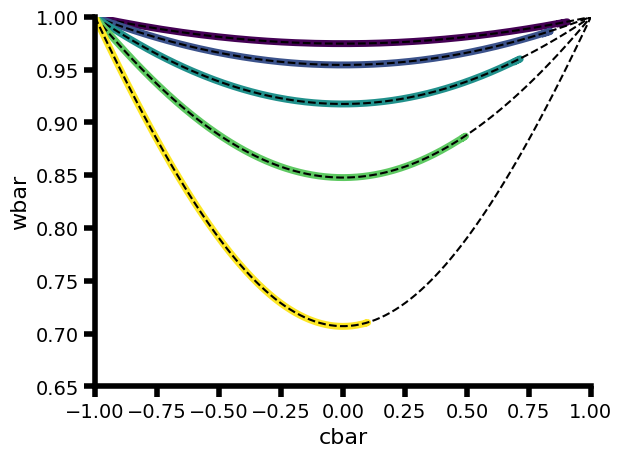

In [11]:
fig

## Make plot showing accuracy of two assumptions
### wbar

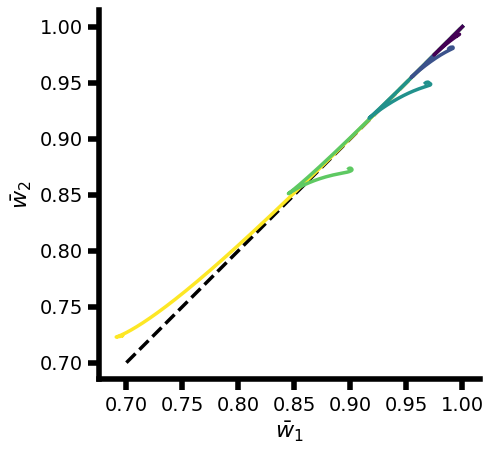

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)


## add a diagonal line through origin
ax.plot([0.7, 1], [0.7, 1], color='black', linestyle='--', label='assumption')


for i, tauc0 in enumerate(np.flip(tauc0s)):
    i = len(tauc0s) - i - 1
    color = cmap(norm(tauc0))
    ax.plot(-(Ws[i, ..., 0, 0] - Ws[i, ..., 1, 0]), -(Ws[i,..., 1, 1] - Ws[i,..., 0, 1]), label=f"tauc0={tauc0:.2g}", color = color, linewidth=3)

ax.set_aspect('equal')

ax.set_xlabel(r"$\bar{w}_1$")
ax.set_ylabel(r"$\bar{w}_2$")

format_axis(ax)

fig

### error

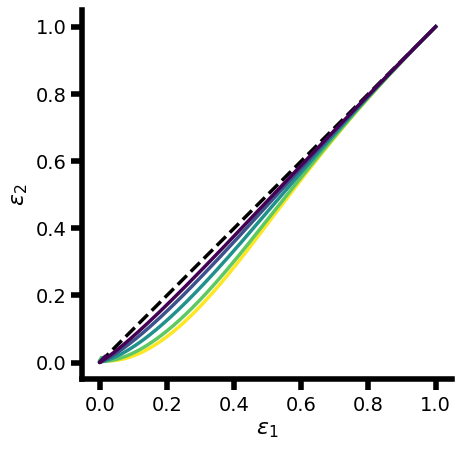

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

## add a diagonal line through origin
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='assumption')

for i, tauc0 in enumerate(np.flip(tauc0s)):
    i = len(tauc0s) - i - 1
    color = cmap(norm(tauc0))
    ax.plot(epsilons[i,...,0], -epsilons[i,...,1], label=f"tauc0={tauc0:.2g}", color = color, linewidth=3, )

ax.set_aspect('equal')

ax.set_xlabel(r"$\varepsilon_1$")
ax.set_ylabel(r"$\varepsilon_2$")

format_axis(ax)

fig

## Make plots showing time dependency

### Epsilon

In [17]:
nt = epsilons.shape[1]
irun = 2
epsilons.shape

(5, 2000, 2)

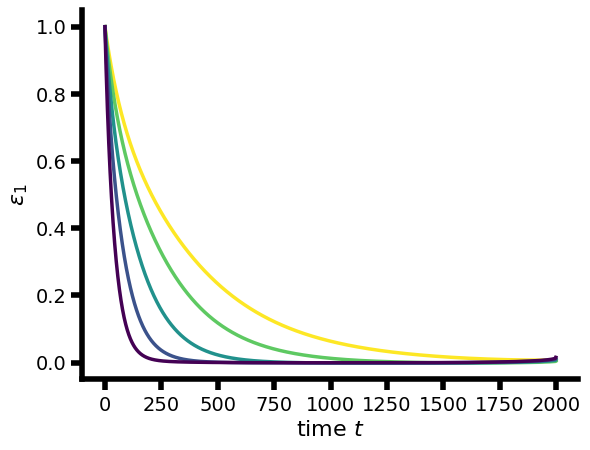

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel(r"time $t$")
ax.set_ylabel(r"$\epsilon_1$")

for i, tauc0 in enumerate(np.flip(tauc0s)):
    i = len(tauc0s) - i - 1
    color = cmap(norm(tauc0))
    ax.plot(epsilons[i, ..., 0], label=f"tauc0={tauc0:.2g}", color = color, linewidth=3, )

format_axis(ax)

ax.set_ylim(-0.05, 1.05)

fig

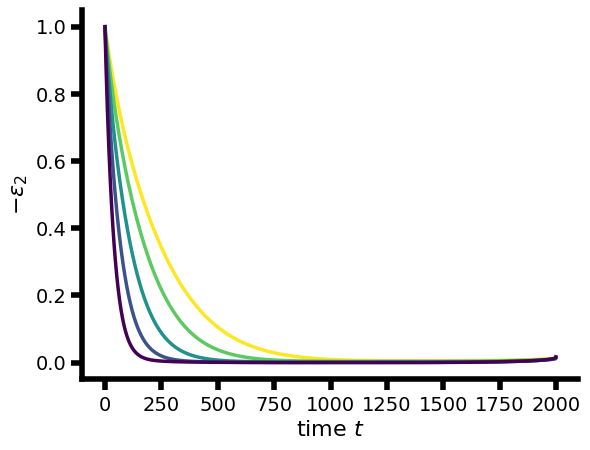

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel(r"time $t$")
ax.set_ylabel(r"$-\epsilon_2$")

for i, tauc0 in enumerate(np.flip(tauc0s)):
    i = len(tauc0s) - i - 1
    color = cmap(norm(tauc0))
    ax.plot(- epsilons[i, ..., 1], label=f"tauc0={tauc0:.2g}", color = color, linewidth=3, )
    
format_axis(ax)

ax.set_ylim(-0.05, 1.05)

fig

### w

In [25]:
wdbars = np.array(wdbars)
wdbars.shape

(5, 2000)

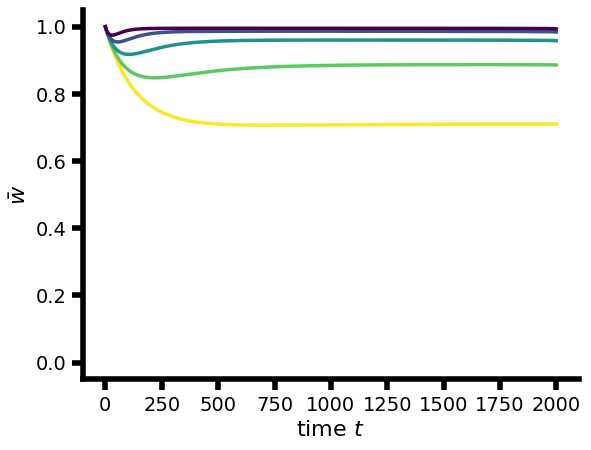

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel(r"time $t$")
ax.set_ylabel(r"$\bar w$")

for i, tauc0 in enumerate(np.flip(tauc0s)):
    i = len(tauc0s) - i - 1
    color = cmap(norm(tauc0))
    ax.plot(wbars[i], label=f"tauc0={tauc0:.2g}", color = color, linewidth=3, )

format_axis(ax)

ax.set_ylim(-0.05, 1.05)

fig

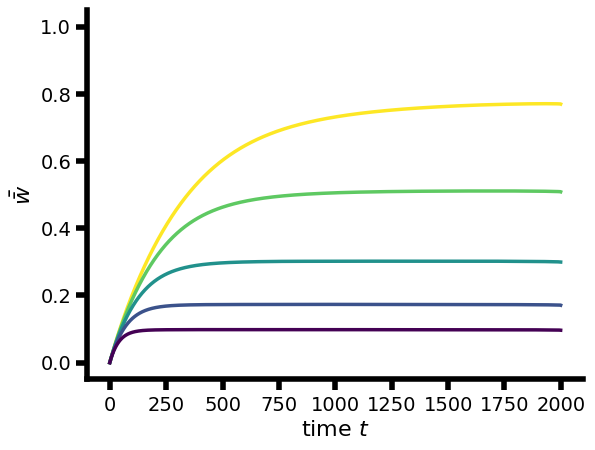

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel(r"time $t$")
ax.set_ylabel(r"$\bar \bar w$")

for i, tauc0 in enumerate(np.flip(tauc0s)):
    i = len(tauc0s) - i - 1
    color = cmap(norm(tauc0))
    ax.plot(wdbars[i], label=f"tauc0={tauc0:.2g}", color = color, linewidth=3, )

format_axis(ax)

ax.set_ylim(-0.05, 1.05)

fig

### c

In [32]:
cdbars = np.array(cdbars)

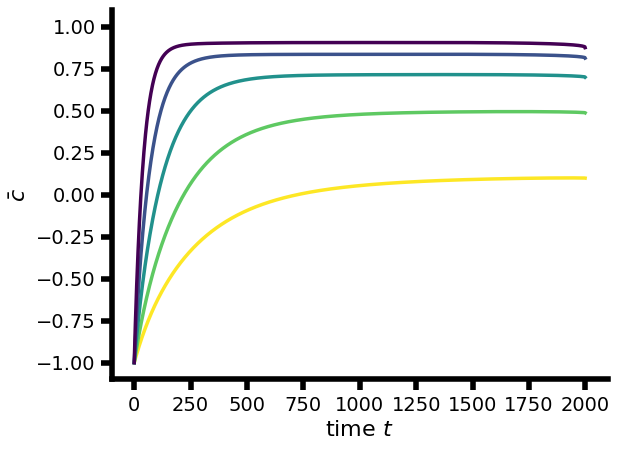

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel(r"time $t$")
ax.set_ylabel(r"$\bar c$")

for i, tauc0 in enumerate(np.flip(tauc0s)):
    i = len(tauc0s) - i - 1
    #color = 'C%d' %i
    color = cmap(norm(tauc0))
    ax.plot(cbars[i], label=f"tauc0={tauc0:.2g}", color = color, linewidth=3, )
format_axis(ax)

ax.set_ylim(-1.1, 1.1)

fig

### Colorbar

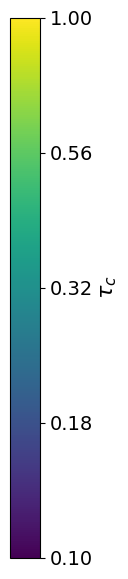

In [10]:
# Create a new figure for the colorbar
fig_colorbar = plt.figure(figsize=(2, 6))  # Adjust the size as needed
ax_colorbar = fig_colorbar.add_axes([0.05, 0.05, 0.15, 0.9])  # Adjust the position and size as needed

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create the colorbar
cbar = plt.colorbar(sm, cax=ax_colorbar)
cbar.set_label('$\\tau_c$', fontsize=16)

# Set the ticks and tick labels for the colorbar based on tauc0 values
cbar.set_ticks(tauc0s)
cbar.set_ticklabels([f'{t:.2f}' for t in tauc0s], fontsize=14)

# Ensure only the specified ticks are shown
cbar.ax.yaxis.set_major_locator(FixedLocator(tauc0s))
cbar.ax.yaxis.set_minor_locator(FixedLocator([]))  # Remove minor ticks
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Format ticks

fig_colorbar

## Symmetric simulation

In [98]:
## Check current levels
print(cbars[:,-2])
print(cdbars[:,-2])
print(wbars[:,-2])
print(wdbars[:,-2])

[0.87988555 0.8158659  0.7008579  0.48791718 0.09891927]
[1.0035107 1.0105408 1.0309366 1.0833021 1.1787804]
[0.9939208  0.98459494 0.95850056 0.88607347 0.7104838 ]
[0.09685728 0.17132857 0.29974216 0.50883627 0.7699957 ]


In [106]:
cs = np.array(cs)
Ws = np.array(Ws)

cs.shape, Ws.shape

((5, 2000, 2), (5, 2000, 2, 2))

In [112]:
t = 500

paramss_init = [
    {
            'c1': jnp.array([c1, c2]),
            'W1': #Y_tgts.reshape(2, 2, 1),
                jnp.array([[w11, w12], [w21, w22]]).reshape(2, 2, 1)
    }
    for c1, c2, w11, w12, w21, w22 in zip(
        cs[:,t,0], 
        cs[:,t,1], 
        Ws[:,t,0,0], Ws[:,t,0,1], 
        Ws[:,t,1,0], Ws[:,t,1,1]
    )
]

In [113]:
paramss_init

[{'c1': Array([0.9545973 , 0.05077519], dtype=float32),
  'W1': Array([[[-0.04984806],
          [ 1.0438042 ]],
  
         [[ 0.9475924 ],
          [ 0.0505944 ]]], dtype=float32)},
 {'c1': Array([0.92431915, 0.0917194 ], dtype=float32),
  'W1': Array([[[-0.08818558],
          [ 1.0709882 ]],
  
         [[ 0.9035052 ],
          [ 0.09026705]]], dtype=float32)},
 {'c1': Array([0.8703107 , 0.18512844], dtype=float32),
  'W1': Array([[[-0.14784472],
          [ 1.106272  ]],
  
         [[ 0.8196338 ],
          [ 0.15966749]]], dtype=float32)},
 {'c1': Array([0.7532575 , 0.39345953], dtype=float32),
  'W1': Array([[[-0.19656453],
          [ 1.1352512 ]],
  
         [[ 0.67690516],
          [ 0.27072167]]], dtype=float32)},
 {'c1': Array([0.55558795, 0.649701  ], dtype=float32),
  'W1': Array([[[-0.1799619 ],
          [ 1.1325382 ]],
  
         [[ 0.5155006 ],
          [ 0.40786475]]], dtype=float32)}]

In [122]:
cbars = []
wbars = []
losses = []
Ws = []
cs = []
epsilons = []

cdbars = []
wdbars = []

for tauc0, params_init in zip(tauc0s, paramss_init):

    from lcs.joint_learning import run_config
    from lcs.configs import Config
    from lcs.plotting_utils import make_cosyne_fig

    block_duration=5
    Y_tgt = get_n_phasic_curriculum(g, block_duration, *Y_tgts)

    c_lr = 1/tauc0
    W_lr = 1.
    tauc = 1/c_lr
    tauw = 1/W_lr

    cfg = Config(**dict(
        num_blocks=2,  # JB need more than 1 block to see a change
        block_duration=block_duration,  # timescale of the context switch
        num_contexts=2,
        num_paths=2,
        output_size=2,
        input_size=1,
        num_seeds=1,
        dt=1e-4,
        T_tape=500,
        regularization_type=[("nonnegative",1), 
                            ("gating_manifold_L1",1), 
                            ("l2_W",0)],
        use_X=False,
        metric='cosine,cols',  # we need to use cols here because W = [[1], [0]] has diverging norm row-wise
        regularization_strength=0.01,
        W_teachers=Y_tgts.reshape(2, 2, 1),
        Y_tgt=Y_tgt,
        c_lr=c_lr,
        W_lr=W_lr,
    )
    )

    tape = run_config(cfg, params_init=params_init)

    c = tape.c1[0]
    cs.append(c)
    cbar = c[..., 0] - c[..., 1]
    cbars.append(cbar)
    cdbar = c[..., 0] + c[...,1]
    cdbars.append(cdbar)

    W = tape.W1[0, ..., 0]
    Ws.append(W)
    Wbar = - ((W[..., 0, 0] - W[..., 0, 1]) + (W[..., 1, 1] - W[..., 1, 0]))/2
    wdbar = - ((W[..., 0, 0] + W[..., 1, 0]) - (W[..., 0, 1] + W[..., 1, 1]))/2
    wdbars.append(wdbar)

    wbars.append(Wbar)
    epsilons.append(tape.y - np.array([0,1]))

    losses.append(tape.loss)

cbars = np.array(cbars)
wbars = np.array(wbars)
losses = np.array(losses).squeeze()
Ws = np.array(Ws)
epsilons = np.array(epsilons).squeeze()
wdbars = np.array(wdbars)
cdbars = np.array(cdbars)

[INFO] [2024-10-15 22:56:29,335] in lcs.joint_learning: Running 1 seeds on device TFRT_CPU_0 with config Config(input_size=1,
       output_size=2,
       num_seeds=1,
       num_contexts=2,
       num_paths=2,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0.01,
       num_layers=1,
       hidden_size=10,
       context_model=True,
       name='',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 1),
                            ('l2_W', 0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum=None,
       Y_tgt=<function get_n_phasic_curriculum.<locals>.Y_tgt at 0x7fc496d48900>,
       W_teachers=Array([[[0.],
        [1.]],

       [[1.],
        [0.]]], dtype=float32),
       use_X=False,
       metric='cosine,cols',
       teacher_mode='orthogonal',
       teacher_xx=0.0,
       t_tot=20,
     

/home/kai/anaconda3/envs/lcs/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3042: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/home/kai/anaconda3/envs/lcs/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3043: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
/home/kai/anaconda3/envs/lcs/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Exp

[[0.0102203 ]
 [0.01124455]]
[INFO] [2024-10-15 22:56:30,276] in lcs.joint_learning: Running 1 seeds on device TFRT_CPU_0 with config Config(input_size=1,
       output_size=2,
       num_seeds=1,
       num_contexts=2,
       num_paths=2,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0.01,
       num_layers=1,
       hidden_size=10,
       context_model=True,
       name='',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 1),
                            ('l2_W', 0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum=None,
       Y_tgt=<function get_n_phasic_curriculum.<locals>.Y_tgt at 0x7fc496d72d40>,
       W_teachers=Array([[[0.],
        [1.]],

       [[1.],
        [0.]]], dtype=float32),
       use_X=False,
       metric='cosine,cols',
       teacher_mode='orthogonal',
       teacher_x

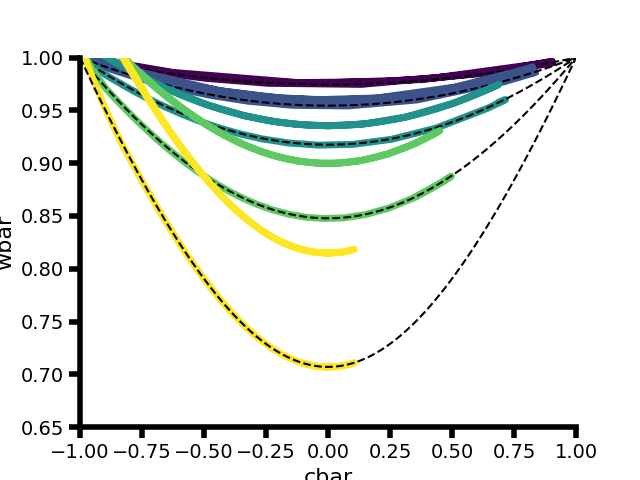

In [123]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim(-1, 1)
ax.set_ylim(0.65, 1)

ax.set_xlabel("cbar")
ax.set_ylabel("wbar")

format_axis(ax)

for i, tauc0 in enumerate(tauc0s):
    color = cmap(norm(tauc0))
    ax.plot(cbars[i], wbars[i], label=f"tauc0={tauc0:.2g}", color=color, linewidth=5)
    ax.plot(cbar_anal, wbars_anal[i],linestyle = '--', color='black')# label=f"tauc0={tauc0}",   ## inline conversions convert from symmetric model scale to output scale

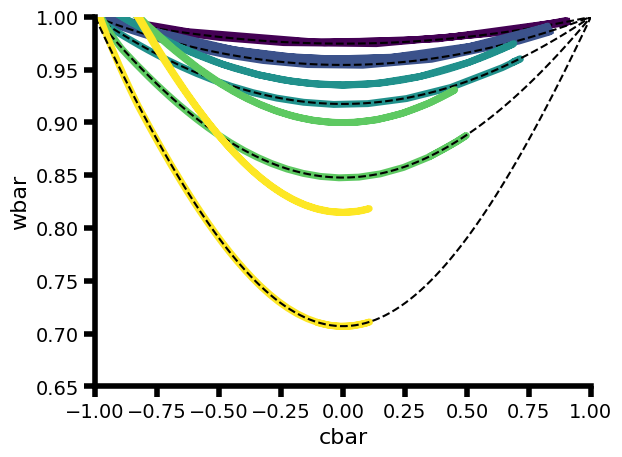

In [124]:
fig